# ハフ変換による直線検出
## 目的
このチュートリアルでは
* ハフ変換の概念を学ぶ．
* 画像から直線を検出をするためのハフ変換の使い方を学ぶ．
* 次の関数の使い方を学ぶ: [cv2.HoughLines()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.houghlines#cv2.HoughLines), [cv2.HoughLinesP()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.houghlines#cv2.HoughLinesP)


## 理論
ハフ変換は数式で表される「形状」を検出するため、広く使われている方法である．しかも形状の一部が破損，劣化していていても検出できるという特徴がある．ここでは「直線」検出のためにどのようにハフ変換を使うかをみることにしよう．

直線は $y = mx+c$ もしくは $\rho = x \cos \theta + y \sin \theta$ と表すことができる。ここで $\rho$ は原点から直線までの距離， $\theta$ は直線の法線と横軸の成す角で、反時計回りの角度を表す(向きは座標系の表現次第で変わる．この表現はOpenCVで使われている表現である)．次の画像をみてみよう:

![coordinate system](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/houghlines1.svg)

もしも直線が原点の下を通過するのであれば$\rho$ は正の値をとり、角度は180度未満である．しかるに原点の上を通過する場合は、角度は180より大きい値になるのではなく、$\rho$ は負の値とする．縦軸に平行な直線の場合は角度が0度，横軸に平行な直線は角度が90度である．

それでは直線検出におけるハフ変換の使い方を見ていこう．先の式が示すように，あらゆる直線は2つのパラメータ $(\rho, \theta)$ を使って表すことができる．まず初めに，この2つのパラメータを保持するために2次元配列もしくは積算機を用意し，初期値として0を与える．行は $\rho$ ，列は $\theta$ を意味する．配列のサイズは、必要とする精度に依存する。角度の精度を1度単位とするのであれば180列必要になる．$ \rho $ については、画像の直交方向の長さを最大値とすればよいだろう．1画素単位での精度が必要であれば、行の数を画像の対角方向の長さに設定する．

例として、解像度が$100 \times 100$の画像において、その中心に横方向の直線があるとしよう．直線上の最初の点に対し，その座標$(x,y)$を調べる．直線を表す式にこの座標を代入し， $\theta = 0,1,2,\ldots,180$ に対して $\rho $の値を計算する．パラメータの各ペア $(\rho, \theta) $に対し，2次元配列で対応する $(\rho, \theta)$ のセルの値を増やす(インクリメントする)．積算機の中では，セル $(50,90) = 1$、などとなる．

同じ直線上の二つ目の点に対しても上記と同様の処理を行う．計算した $ (\rho, \theta)$ に対応するセルを増やす(インクリメントする)．ここでセル $(50,90) = 2$ となる．ここでしていることは $(\rho, \theta)$ に対する「投票」である．この処理を直線上の全点に対して行なう．直線上の各点によりセル(50,90)に対して投票がされる一方，他のセルへの投票は増えない．このようにして最終的にセル$(50,90)$が最大投票数を得ることになる．積算機中の最大投票数を調べれば$(50,90)$のセルが見つかり，これは距離が50，角度が90度の直線が検出できたことを意味する．この投票処理を以下のアニメーションに示す(画像引用: [Amos Storkey](http://homepages.inf.ed.ac.uk/amos/hough.html) )．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/houghlinesdemo.gif)

これがハフ変換を使った直線検出の仕組みである．単純なアルゴリズムなので，自分自身の手で実装する事もできよう．次の画像は積算機を可視化したものである．明るい場所が画像中の可能性がある直線に対応するパラメータの場所を表している(画像引用: [Wikipedia](http://en.wikipedia.org/wiki/Hough_transform) )．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/houghlines2.jpg)

## OpenCVを使ったハフ変換
上での述べたアルゴリズムはOpenCVの [cv2.HoughLines(image, rho, theta, threshold[, lines[, srn[, stn[, min_theta[, max_theta]]]]])](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.houghlines#cv2.HoughLines) 関数で実装されている．戻り値は  $(\rho, \theta)$ の配列である． $\rho $は画素単位で計測され， $\theta$ はradian単位で計算される．第1引数`Image`は入力画像で，2値画像でなければならない．あらかじめ2値化やエッジ検出をした画像を使うと良いだろう．第2,3引数`(rho, theta)`にはそれぞれ $\rho $と $\theta$ の精度を指定する．第4引数`threshold`は，直線とみなされるのに必要な最低限の投票数を意味する閾値である．覚えているだろうか、この投票数は直線上の点の数に依存することを。つまり，この閾値とは検出可能な線の長さの最小値を表している ([使用する画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_houghlines/dave.jpg))

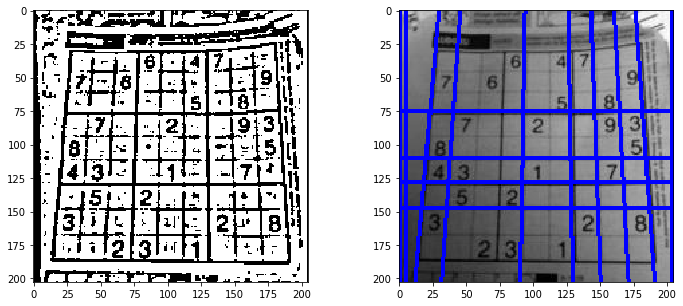

In [6]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,11,2)

edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,102)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

# cv2.imwrite('houghlines3.jpg',img)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(gray,'gray')
plt.subplot(1,2,2)
plt.imshow(img)
plt.show()

## 確率的ハフ変換
上記のハフ変換は，たった二つのパラメータを計算するのに大量の計算を必要とする．そこで確率的ハフ変換は、ハフ変換の最適化を行ったものとみなせるだろう．この手法は直線検出をするために、全部の画素を使って計算するのではなく，検出に十分な数の点だけを画像からランダムに選択して計算する．ここで我々がすべき作業は閾値を減らすことだけである．次の画像はハフ空間において、ハフ変換と確率的ハフ変換を比較した画像である(画像引用 : [Franck Bettinger’s home page](http://phdfb1.free.fr/robot/mscthesis/node14.html) )．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/houghlines4.png)

OpenCVによる実装は，Matas, J., Galambos, C. & Kittler, J.V.が提案した「漸進的確率的ハフ変換」を使ってロバストな直線検出を行なうものである．使用するのは２つの引数を入力とする [cv2.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]))](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.houghlines#cv2.HoughLinesP)関数である．
* オプション引数`minLineLength` : 検出する直線の最小の長さを表す．この値より短い線分は検出されない．
* オプション引数`maxLineGap` :二つの線分を一つの直線とみなす時に許容される最大の長さを表す．この値より小さいギャップを持つ２本の直線は一つの直線とみなされる．

直線を表す最良の方法は、その両端点を返すことである．前の例では直線のパラメータを取得したため，直線上の全点を計算する必要があった．今回は全てが直接的で単純である (コードと画像)

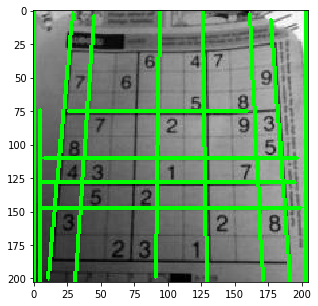

In [8]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,11,2)

edges = cv2.Canny(gray,50,150,apertureSize = 3)
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=20,maxLineGap=20)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

#cv2.imwrite('houghlines5.jpg',img)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

## 補足資料
* [Wikipediaのハフ変換(英語)](http://en.wikipedia.org/wiki/Hough_transform)

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: OpenCVを使った画像処理
OpenCVが提供する様々な画像処理の関数について学ぶ
* 前の学習項目: [テンプレートマッチング templateMatching.ipynb ](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/templateMatching.html)<BR>
テンプレートマッチングを使った物体検出を学ぶ．
* 次の学習項目: [ハフ変換による円検出 houghCircles.ipynb ](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/houghCircles.html)<BR>
画像中の円の検出方法を学ぶ